In [9]:
import tensorflow as tf

In [10]:
from tensorflow_examples.models.pix2pix import pix2pix

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from pathlib import Path
import os

In [13]:
# Classes
num_classes = 2

# Epochs
n_epochs = 10

# Tamanho imagem
img_rows, img_cols = 128, 128

input_shape = (img_rows, img_cols, 3)

#Batch size

batch_size = 32

# seed
seed=42

path_dataset = Path('/scratch/dpfurtado/pilheira_new_home/segmentacao/dataset/')
path_train = path_dataset/'train'/'JPEGImages'
path_train_dev = path_dataset/'train-dev'/'JPEGImages'
path_train_mask = path_dataset/'train'/'SegmentationClassPNG_binario'
path_train_dev_mask = path_dataset/'train-dev'/'SegmentationClassPNG_binario'


In [14]:
from PIL import Image
import glob
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [17]:
str(path_train)

'/scratch/dpfurtado/pilheira_new_home/segmentacao/dataset/train/JPEGImages'

In [19]:
#Capture training image info as a list
train_images = []
train_images_raw = []

image_names_train = glob.glob(str(path_train/'*.jpg'))
image_names_train.sort()

image_names_train_dev = glob.glob(str(path_train_dev/'*.jpg'))
image_names_train_dev.sort()

for img_path in image_names_train:
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = img.resize((img_rows, img_cols))
    img = np.array(img)
    train_images_raw.append(img)
    img = preprocess_input(img)
    train_images.append(img)
    
for img_path in image_names_train_dev:
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = img.resize((img_rows, img_cols))
    img = np.array(img)
    train_images_raw.append(img)
    img = preprocess_input(img)
    train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
train_images_raw = np.array(train_images_raw)

In [20]:
train_images.shape

(1070, 128, 128, 3)

In [21]:
#Capture training image info as a list
masks = []

mask_names_train = glob.glob(str(path_train_mask/'*.png'))
mask_names_train.sort()

mask_names_train_dev = glob.glob(str(path_train_dev_mask/'*.png'))
mask_names_train_dev.sort()

for img_path in mask_names_train:
    img = Image.open(img_path)
    img = img.resize((img_rows, img_cols))
    img = np.array(img)
    masks.append(img)
       
for img_path in mask_names_train_dev:
    img = Image.open(img_path)
    img = img.resize((img_rows, img_cols))
    img = np.array(img)
    masks.append(img)
#Convert list to array for machine learning processing        
mask_dataset = np.array(masks)

In [22]:
mask_dataset.shape

(1070, 128, 128)

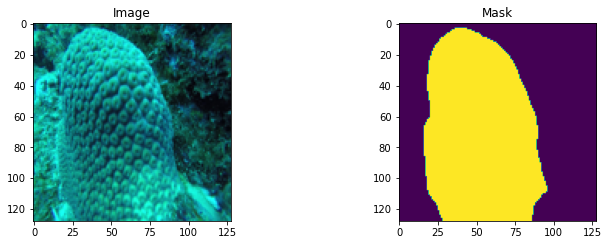

In [23]:
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images_raw[img_number]
mask = mask_dataset[img_number]
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, mask_dataset))

2022-05-18 20:43:33.568938: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-18 20:43:33.571128: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-18 20:43:34.436688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-05-18 20:43:34.437328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-05-18 20:43:34.437413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

In [25]:
train_dataset = train_dataset.shuffle(1000).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [27]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [28]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [29]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [31]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [32]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [33]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        raw = display_list[i].numpy()
        convert = (raw+1)/2
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(convert)
        plt.axis('off')
    plt.show()

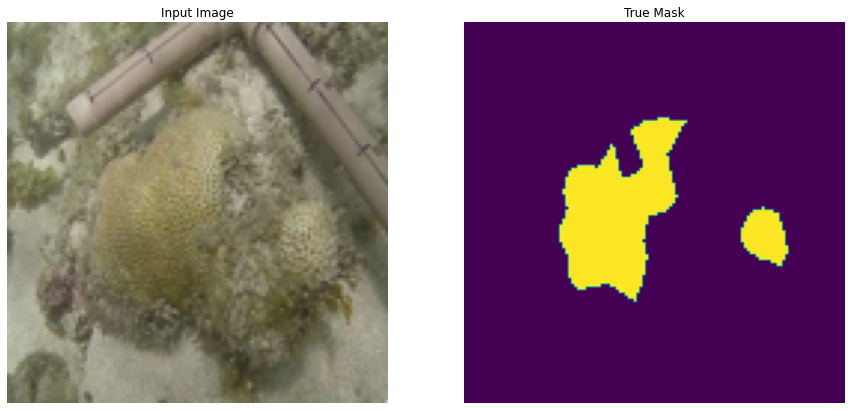

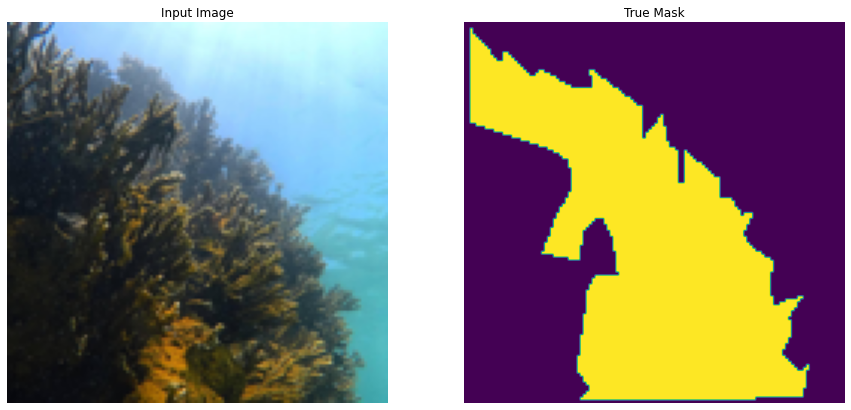

2022-05-18 20:43:42.440225: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [34]:
for images, masks in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

2022-05-18 20:43:42.563302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-18 20:43:42.583410: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-05-18 20:43:43.456288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-18 20:43:44.305302: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


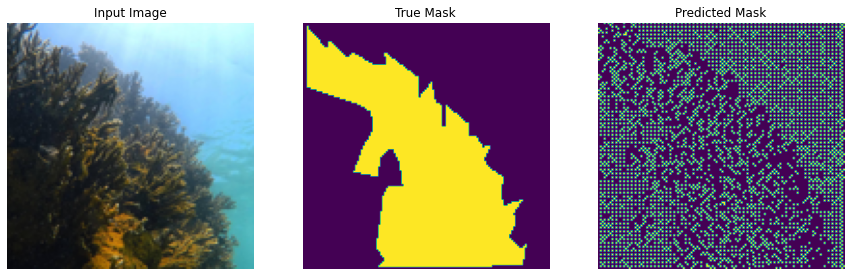

In [35]:
show_predictions()

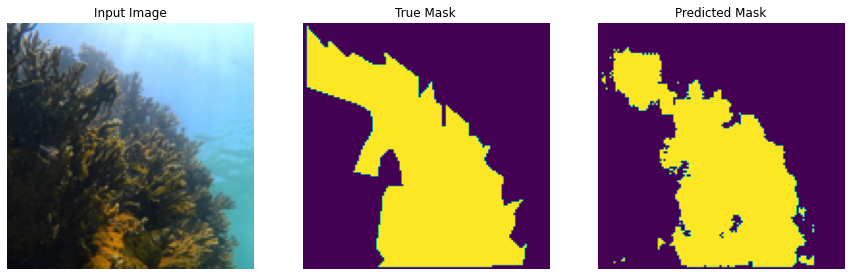


Sample Prediction after epoch 20



In [37]:
EPOCHS = 20

model_history = model.fit(train_dataset, epochs=EPOCHS,
                         callbacks=[DisplayCallback()])

In [38]:
model.save('./model/pix2pix')

2022-05-18 20:45:32.581894: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model/pix2pix/assets
